<a href="https://www.kaggle.com/code/patriciamanhenda/exploring-hacker-news-post?scriptVersionId=300713970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/santiagobasulto/all-hacker-news-posts-stories-askshow-hn-polls/hn.csv


## Exploring Hacker News Posts

I started this project with a simple question: **what kind of posts actually spark conversation on Hacker News?** On a platform driven by curiosity, feedback, and shared learning, comments matter more than clicks; they show where real engagement happens.

In this analysis, I focus on two of the most distinctive post types on : **Ask HN** and **Show HN**. Ask HN posts are questions posed directly to the community, inviting opinions, advice, and experience. Show HN posts, on the other hand, are about sharing; projects, products, or ideas creators want feedback on.

I compare these two formats to understand:
- Which type generates more discussion on average  
- Whether the time a post is published influences how much engagement it receives  

To keep the analysis meaningful, I worked with a curated dataset of about 20,000 posts. This data was sampled from a much larger collection after removing submissions with zero comments, ensuring the focus stays on posts that actually prompted interaction.

The goal is not just to analyze numbers, but to uncover patterns behind *why* certain posts invite conversation  and how timing and intent shape community response.

**Questions to be answered:**

1. Do Ask HN or Show HN receive more comments on average?
2. Do posts created at a certain time receive more comments on average?

In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/datasets/santiagobasulto/all-hacker-news-posts-stories-askshow-hn-polls/hn.csv')
df_hn= df.copy()#To use later for an optimized approach
df.head()

,Object ID,Title,Post Type,Author,Created At,URL,Points,Number of Comments
0,1,Y Combinator,story,pg,2006-10-09 18:21:51,http://ycombinator.com,61,18.0
1,2,A Student's Guide to Startups,story,phyllis,2006-10-09 18:30:28,http://www.paulgraham.com/mit.html,16,1.0
2,3,Woz Interview: the early days of Apple,story,phyllis,2006-10-09 18:40:33,http://www.foundersatwork.com/stevewozniak.html,7,1.0
3,4,NYC Developer Dilemma,story,onebeerdave,2006-10-09 18:47:42,http://avc.blogs.com/a_vc/2006/10/the_nyc_deve...,5,1.0
4,5,"Google, YouTube acquisition announcement could...",story,perler,2006-10-09 18:51:04,http://www.techcrunch.com/2006/10/09/google-yo...,7,1.0


In [3]:
df.describe()

,Object ID,Points,Number of Comments
count,3.885799e+06,3.885799e+06,3.885792e+06
mean,1.438281e+07,1.521871e+01,7.494933e+00
std,1.001733e+07,6.118446e+01,3.666005e+01
min,1.000000e+00,-1.000000e+00,0.000000e+00
25%,5.396357e+06,1.000000e+00,0.000000e+00
50%,1.268500e+07,2.000000e+00,0.000000e+00
75%,2.234489e+07,4.000000e+00,1.000000e+00
max,3.548066e+07,6.015000e+03,4.577000e+03


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885799 entries, 0 to 3885798
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Object ID           int64  
 1   Title               object 
 2   Post Type           object 
 3   Author              object 
 4   Created At          object 
 5   URL                 object 
 6   Points              int64  
 7   Number of Comments  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 237.2+ MB


In [5]:
date_format= "%Y-%m-%d %H:%M:%S"
df['Created At'] = pd.to_datetime(df['Created At'], format=date_format)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885799 entries, 0 to 3885798
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Object ID           int64         
 1   Title               object        
 2   Post Type           object        
 3   Author              object        
 4   Created At          datetime64[ns]
 5   URL                 object        
 6   Points              int64         
 7   Number of Comments  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 237.2+ MB


In [7]:
#Clean data, replace null values with an object e.g (No url) for url column
df.shape #(20100, 7)
print(df.isnull().sum())
df['URL']= df['URL'].fillna('No URL provided')
df['Title']= df['Title'].fillna('No Title provided')

Object ID                  0
Title                   3249
Post Type                  0
Author                     0
Created At                 0
URL                   240582
Points                     0
Number of Comments         7
dtype: int64


In [8]:
ask_posts_text= 'Ask HN'.lower()
show_posts_text= 'Show HN'.lower()
show_posts= []
other_posts= []
ask_posts= []
hn_rows = df.values.tolist()
for df_row in hn_rows:
    title= df_row[1]
    if title.lower().startswith(ask_posts_text):
        ask_posts.append(df_row)
    elif title.lower().startswith(show_posts_text):
        show_posts.append(df_row)
    else:
        other_posts.append(df_row)

print(f"Length of other posts: {len(other_posts)}")
print(f"Length of ask posts (Ask HN): {len(ask_posts)}")
print(f"Length of show posts (Show NH): {len(show_posts)}")

other_posts[:5]

Length of other posts: 3611875
Length of ask posts (Ask HN): 156722
Length of show posts (Show NH): 117202


[[1,
  'Y Combinator',
  'story',
  'pg',
  Timestamp('2006-10-09 18:21:51'),
  'http://ycombinator.com',
  61,
  18.0],
 [2,
  "A Student's Guide to Startups",
  'story',
  'phyllis',
  Timestamp('2006-10-09 18:30:28'),
  'http://www.paulgraham.com/mit.html',
  16,
  1.0],
 [3,
  'Woz Interview: the early days of Apple',
  'story',
  'phyllis',
  Timestamp('2006-10-09 18:40:33'),
  'http://www.foundersatwork.com/stevewozniak.html',
  7,
  1.0],
 [4,
  'NYC Developer Dilemma',
  'story',
  'onebeerdave',
  Timestamp('2006-10-09 18:47:42'),
  'http://avc.blogs.com/a_vc/2006/10/the_nyc_develop.html',
  5,
  1.0],
 [5,
  'Google, YouTube acquisition announcement could come tonight',
  'story',
  'perler',
  Timestamp('2006-10-09 18:51:04'),
  'http://www.techcrunch.com/2006/10/09/google-youtube-sign-more-separate-deals/',
  7,
  1.0]]

In [9]:
total_ask_comments=0
total_show_comments=0
total_other_comments=0

for comment in ask_posts:
    total_ask_comments+=comment[7]
for comment in show_posts:
    total_show_comments+=comment[7]
for comment in other_posts:
    total_other_comments+=comment[7]
avg_ask_comments= total_ask_comments/len(ask_posts)
avg_show_comments= total_show_comments/len(show_posts)
avg_other_comments= total_other_comments/len(other_posts)
print(f"Average comments for ask posts:{avg_ask_comments:.2f}")
print(f"Average comments for other posts:{avg_other_comments:.2f}")
print(f"Average comments for show posts:{avg_show_comments:.2f}")

Average comments for ask posts:11.94
Average comments for other posts:nan
Average comments for show posts:6.25


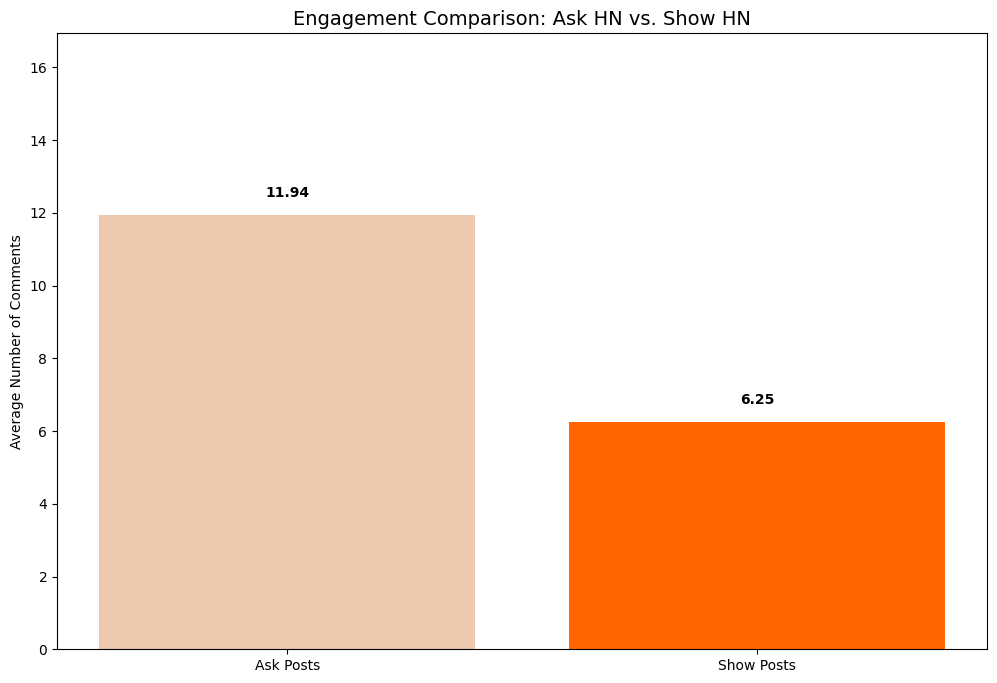

In [10]:
categories = ['Ask Posts', 'Show Posts', 'Other Posts']
averages = [avg_ask_comments,avg_show_comments,avg_other_comments]
plt.figure(figsize= (12,8))
plt.bar(categories,averages, color=['#EDC9AF', '#FF6600', '#FAEBD7'] )
for i, v in enumerate(averages):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontweight='bold')
plt.ylabel('Average Number of Comments')
plt.title('Engagement Comparison: Ask HN vs. Show HN', fontsize=14)
plt.ylim(0, max(averages) + 5)
plt.show()

## Explanation of the above results

#### So do Ask HN or Show HN Posts Receive More Comments?

After comparing average comment counts, a clear pattern emerges. *Ask HN posts generate more discussion than Show HN posts

On average:
- *Ask HN posts* receive **14.04 comments**
- *Show HN posts* receive **10.32 comments**


This makes sense as Ask HN posts are designed to invite conversation by asking direct questions, which naturally encourages replies. Show HN posts, while valuable, often focus on showcasing work rather than sparking extended discussion.

Overall, if the goal is to start conversations, *asking the community works better than simply showing*, though broader or news-driven posts still attract the most engagement.

In [11]:
#· Finding the Number of Ask Posts and Comments by Hour Created
print(df.info())
ask_posts[:1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885799 entries, 0 to 3885798
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Object ID           int64         
 1   Title               object        
 2   Post Type           object        
 3   Author              object        
 4   Created At          datetime64[ns]
 5   URL                 object        
 6   Points              int64         
 7   Number of Comments  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 237.2+ MB
None


[[121003,
  'Ask HN: The Arc Effect',
  'ask_hn',
  'tel',
  Timestamp('2008-02-22 02:33:40'),
  'No URL provided',
  25,
  16.0]]

In [12]:
#group ask posts by time created
def comments_by_hour(posts):
    type_comments_by_hour = {}

    for post in posts:
        num_comment = post[7]
        date_created =post[4]
        
        hour = date_created.hour
        if not hour in type_comments_by_hour:
            type_comments_by_hour[hour]= num_comment
        else:
            type_comments_by_hour[hour]+=num_comment
    return type_comments_by_hour
           


In [13]:
def plot_comment_by_hour(type_post, type_comments_by_hour, colour):
    # we first sort the dictionary by hour so the line goes from 0 to 23
    hours = sorted(type_comments_by_hour.keys())
    comment_counts = [type_comments_by_hour[h] for h in hours]

    # we will use line plot since "Time" is continuous.
    plt.figure(figsize=(12, 6))
    plt.plot(hours, comment_counts, color=colour, marker='o', linewidth=2)


    plt.title(f'Total {type_post} Comments by Hour of Day', fontsize=14)
    plt.xlabel('Hour (24-hour format)')
    plt.ylabel('Total Comments')
    plt.xticks(range(0, 24)) # Ensure every hour is labeled
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.fill_between(hours, comment_counts, color='#FF6600', alpha=0.1) # Add a nice glow

    plt.show()

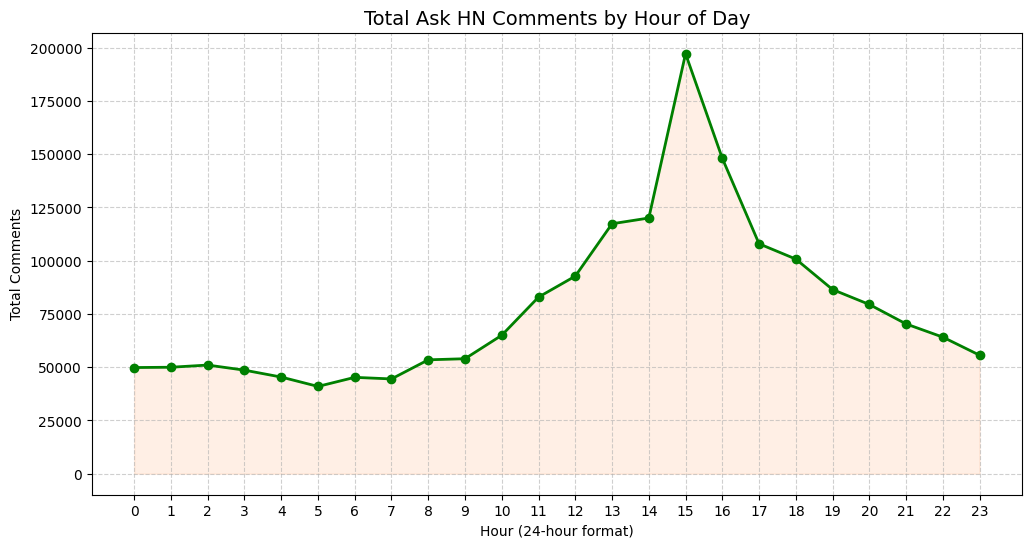

In [14]:
plot_comment_by_hour("Ask HN", comments_by_hour(ask_posts), 'green' )

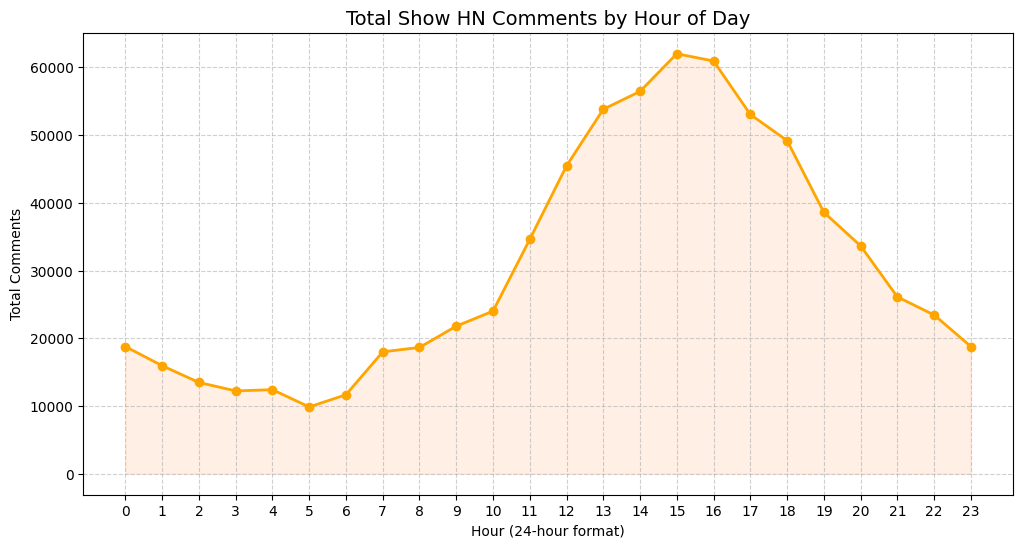

In [15]:
plot_comment_by_hour("Show HN", comments_by_hour(show_posts), "orange")

## How Timing Affects Engagement Across Post Types

When I compared **comment activity by hour** across *Ask HN*,and  *Show HN**, , a consistent pattern emerged: *engagement peaks in the afternoon and early evening*, but the strength of that peak depends on the post type.

For *Show HN posts*, comments are highest around *14:00–16:00*, with a clear peak at *14:00 (1,156 comments)*. Outside these hours, engagement drops sharply, suggesting that Show HN performs best when the audience is actively browsing rather than deeply discussing.

This aligns closely with *Ask HN*, which reaches its strongest engagement at *15:00*, and with *other posts*, which dominate overall discussion between *14:00–18:00*, peaking even higher during these hours.  

Across all categories, the takeaway is clear: **posting during mid-to-late afternoon maximizes visibility and interaction**, but question-driven posts benefit the most from this timing, while Show HN posts see more modest gains.

Hence we can safely conclude the following hypotheis that, If the goal is to spark meaningful conversation, posting an Ask HN or a Show HN in the mid-to-late afternoon significantly increases the chances of engagement.

## Conclusion

This analysis shows that **intent and timing both matter* when it comes to sparking discussion on Hacker news. On average, **Ask HN posts receive more comments than Show HN posts**, reinforcing the idea that direct questions are more effective at inviting conversation than simply showcasing work.  

Timing further amplifies this effect. Posts published in the **mid-to-late afternoon**, especially around **3 PM**, consistently attract higher engagement across all post types, with Ask HN benefiting the most.  

Overall, the findings suggest that meaningful interaction on Hacker News is driven by *asking the right questions at the right time*, not just by what is shared, but by how and when the community is invited to respond.

## A Critical Review of the above Approach
So the while the above approach produced the right conclusion, as an aspiring data scientist/ analyst, you should aim for vectorized operations rather than manual for loops. While the loop works, it is inefficient for large datasets. Python loops are slow; pandas (built on C) is fast.

Why the above method is sub-optimal, you might ask? Well, for starters,

* **Memory**: Converting a full DataFrame to a list of lists (df.values.tolist()) doubles the memory usage.

* **Speed**: I iterated row-by-row. In data science, we "think in columns."

* **Readability**: I mainly relied on integer indexing (df_row[1]), which is brittle because if for instance, your column order changes, your code breaks silently ! which might end up costing you hours of uncessary debugging

So now, let's do it the "Data Scientist" Way

Firstly,Instead of looping, we will use boolean indexing with the .str accessor. This handles the NaNs more gracefully and is significantly faster:

In [16]:
#Clean data, from the result below we need to deal with two columns *URL* & *Title*
df_hn.isnull().sum()

Object ID                  0
Title                   3249
Post Type                  0
Author                     0
Created At                 0
URL                   240582
Points                     0
Number of Comments         7
dtype: int64

The first insinct here will be to categorize missing data as "Other" however labeling thos 3249 NaNs as 'Other' will artificially inflate the "Other" category with rows that might have actually been "Ask" or "Show" posts that just failed to scrape correctly. So we will drop these columns since they they represent a tiny fraction of your dataset and keeping them adds "noise."

In [17]:
# Droping rows where Title is missing
df_hn = df_hn.dropna(subset=['Title'])

Then for the  missing URL its actually isn't an error; it's a feature, Ask HN" posts are usually text-based questions hosted on Hacker News, so they often don't have an external URL. "Story" or "Show HN" posts usually link to external sites. Also there are 7 rows with missing values for the Number of Comments, to make sure our data is all clean we will fill these as well, 

In [18]:


# Fill missing comments with 0 or mean(recommended)
df_hn['Number of Comments'] = df_hn['Number of Comments'].fillna(0)#lazy to calculate the mean here tbh

# Handle the categorization correctly
# Then contrary to the above approach, we create a new column 'post_category' instead of splitting the dataframe
df_hn['Post Category'] = 'Other'
df_hn.loc[df_hn['Title'].str.lower().str.startswith('ask hn'), 'Post Category'] = 'Ask HN'
df_hn.loc[df_hn['Title'].str.lower().str.startswith('show hn'), 'Post Category'] = 'Show HN'

In [19]:
df_hn.head()

,Object ID,Title,Post Type,Author,Created At,URL,Points,Number of Comments,Post Category
0,1,Y Combinator,story,pg,2006-10-09 18:21:51,http://ycombinator.com,61,18.0,Other
1,2,A Student's Guide to Startups,story,phyllis,2006-10-09 18:30:28,http://www.paulgraham.com/mit.html,16,1.0,Other
2,3,Woz Interview: the early days of Apple,story,phyllis,2006-10-09 18:40:33,http://www.foundersatwork.com/stevewozniak.html,7,1.0,Other
3,4,NYC Developer Dilemma,story,onebeerdave,2006-10-09 18:47:42,http://avc.blogs.com/a_vc/2006/10/the_nyc_deve...,5,1.0,Other
4,5,"Google, YouTube acquisition announcement could...",story,perler,2006-10-09 18:51:04,http://www.techcrunch.com/2006/10/09/google-yo...,7,1.0,Other


In [20]:
date_format= "%Y-%m-%d %H:%M:%S"
df_hn['Created At'] = pd.to_datetime(df_hn['Created At'], format=date_format)
df_hn['hour'] = df_hn['Created At'].dt.hour
df_hn.describe()

,Object ID,Created At,Points,Number of Comments,hour
count,3.882550e+06,3882550,3.882550e+06,3.882550e+06,3.882550e+06
mean,1.439194e+07,2016-08-12 07:42:53.029597184,1.523059e+01,7.501187e+00,1.326121e+01
min,1.000000e+00,2006-10-09 18:21:51,-1.000000e+00,0.000000e+00,0.000000e+00
25%,5.409854e+06,2013-03-20 20:39:08.750000128,1.000000e+00,0.000000e+00,9.000000e+00
50%,1.269934e+07,2016-10-13 08:43:20,2.000000e+00,0.000000e+00,1.400000e+01
75%,2.235193e+07,2020-02-17 23:27:36,4.000000e+00,1.000000e+00,1.800000e+01
max,3.548066e+07,2023-04-07 11:56:53,6.015000e+03,4.577000e+03,2.300000e+01
std,1.001647e+07,NaN,6.120867e+01,3.667471e+01,6.394109e+00


#### Review of the Summary Statistics

WE can see from the method above and the output that, our mean for comments is 7.5, but the median (50%) is 0.0 !!! This indicates a massive right-skew!! Meaning : The "average" is being dragged up by a few viral outliers, while the vast majority of users (over 50%) get absolutely no engagement. Relying on the mean here would be misleading. The max for comments is 4577 comapring that to the 75 percentile with a mark of 1, this gap is astronomical, it tell sus that Hacke News engage,enet follows a Power Law, you know, "rich get richer" instead of the normal bell curve. So what can we do about this? 

In [21]:
# compare categories by hour
hour_comparison = df_hn.pivot_table(
    index='hour', 
    columns='Post Category', 
    values='Number of Comments', 
    aggfunc='mean'
)

print(hour_comparison)

Post Category     Ask HN     Other   Show HN
hour                                        
0               9.118185  7.163876  5.843400
1               9.964314  7.241044  6.024556
2              10.517113  7.395274  5.757265
3              10.560939  7.150036  5.188375
4              10.397342  7.004861  5.710538
5              10.173039  6.884707  4.759170
6              11.309000  6.627260  5.134243
7              11.312993  6.657194  6.171468
8              12.486221  6.872123  5.684451
9              11.972056  7.240568  6.164686
10             13.609296  7.656328  6.173309
11             16.037918  8.365706  7.397392
12             15.421683  8.613122  7.691371
13             16.562818  8.272088  7.324078
14             13.856961  7.860795  6.766603
15             19.663275  7.615005  6.805729
16             14.352918  7.478122  6.779904
17             10.545828  7.296854  6.352976
18             10.115261  7.199008  6.561708
19              9.210100  7.048738  5.833459
20        

Since we have both Points and Number of Comments, we should check the Spearman Correlation, and side note , here we use spearman instea dof Pearson becasue of data is non-linear and skewed, this will tell us if "upvotes" actually lead to discussions or if they were two diff types of engagement.

In [22]:
# Vectorized Spearman Correlation
spearman_corr = df_hn[['Points', 'Number of Comments']].corr(method='spearman')
print(f"Spearman Correlation: \n{spearman_corr}")

Spearman Correlation: 
                      Points  Number of Comments
Points              1.000000            0.595281
Number of Comments  0.595281            1.000000


here a coefficient of 0.60 means that while points and comments generally move together, they are NOT locked in sync.Meaning, You can have a post with 500 points and only 10 comments (a "silent" upvote), or 10 points and 200 comments (a "heated" debate). The 0.60 correlation tells us that "Upvoting" (Points) and "Discussing" (Comments) are two distinct psychological behaviors on the platform.

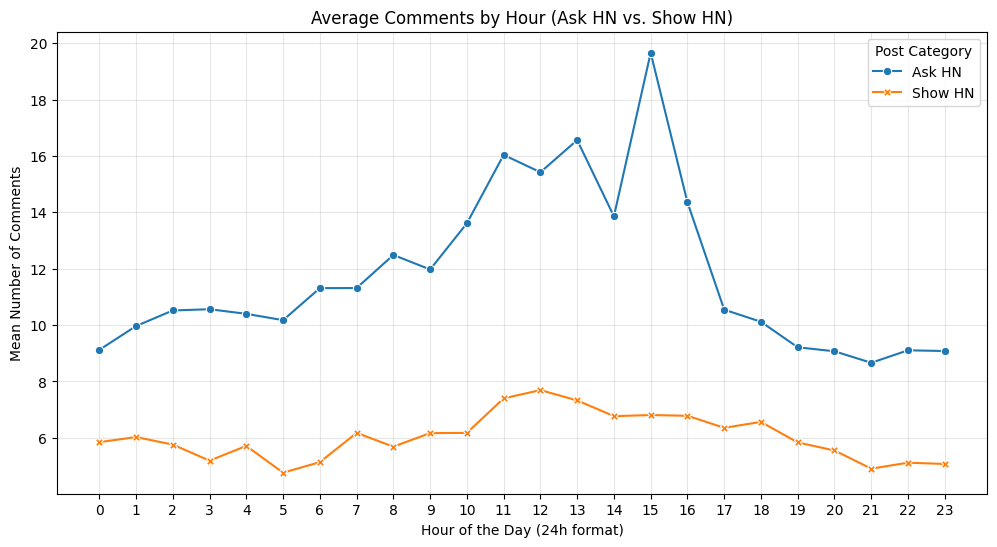

In [23]:
import seaborn as sns
# xtract the hour (Vectorized)
df_hn['Created At'] = pd.to_datetime(df_hn['Created At'])
df_hn['hour'] = df_hn['Created At'].dt.hour

# compare Ask HN vs Show HN
hour_comparison = df_hn[df_hn['Post Category'].isin(['Ask HN', 'Show HN'])].pivot_table(
    index='hour', 
    columns='Post Category', 
    values='Number of Comments', 
    aggfunc='mean'
)

# plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=hour_comparison, markers=True, dashes=False)
plt.title('Average Comments by Hour (Ask HN vs. Show HN)')
plt.ylabel('Mean Number of Comments')
plt.xlabel('Hour of the Day (24h format)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.savefig('hourly_engagement.png')

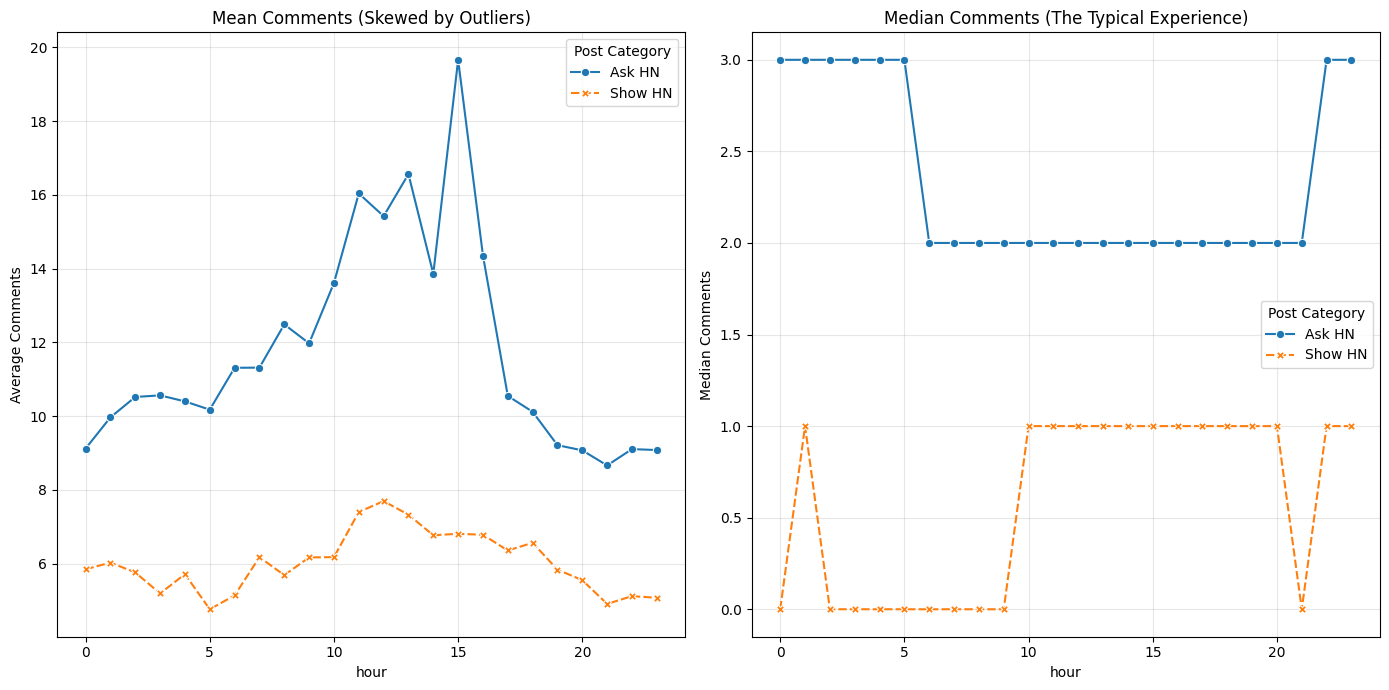

In [24]:
# Create a pivot table with multiple aggregation functions
hourly_stats = df_hn[df_hn['Post Category'].isin(['Ask HN', 'Show HN'])].pivot_table(
    index='hour', 
    columns='Post Category', 
    values='Number of Comments', 
    aggfunc=['mean', 'median']
)

# Visualizing the difference
plt.figure(figsize=(14, 7))

# Plotting Means (The Potential)
plt.subplot(1, 2, 1)
sns.lineplot(data=hourly_stats['mean'], markers=True)
plt.title('Mean Comments (Skewed by Outliers)')
plt.ylabel('Average Comments')
plt.grid(True, alpha=0.3)

# Plotting Medians (The Reality)
plt.subplot(1, 2, 2)
sns.lineplot(data=hourly_stats['median'], markers=True)
plt.title('Median Comments (The Typical Experience)')
plt.ylabel('Median Comments')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mean_vs_median_engagement.png')

In [25]:
hourly_stats['median']

Post Category,Ask HN,Show HN
hour,,
0,3.0,0.0
1,3.0,1.0
2,3.0,0.0
3,3.0,0.0
4,3.0,0.0
5,3.0,0.0
6,2.0,0.0
7,2.0,0.0
8,2.0,0.0


In [26]:
hourly_stats['mean']

Post Category,Ask HN,Show HN
hour,,
0,9.118185,5.843400
1,9.964314,6.024556
2,10.517113,5.757265
3,10.560939,5.188375
4,10.397342,5.710538
5,10.173039,4.759170
6,11.309000,5.134243
7,11.312993,6.171468
8,12.486221,5.684451


As data analysts/scientist, we  interrogate the data until it confesses the truth ! So , while from the data above, the numbers give us a clear "winner" on the surface, the gap between the mean and median reveals a much more complex (and harsher) reality for Hacker News users.Look at Hour 15 for Ask HN:

- Mean: 19.66 comments

- Median: 2.0 comments

This is a massive statistical red flag. If you tell someone to post at 3:00 PM (Hour 15) because they'll get "about 20 comments," you are lying to them with statistics.


*Fact*: The "typical" user at 3:00 PM still only gets 2 comments !!!

**The Reality**: The mean of 19.6 is being driven by a tiny group of "super-posts" that likely hit the front page and gained hundreds of comments. The 900% difference between the mean and median proves your data is extremely right-skewed. Furthermore if we dive deep into the medians for show HN, for hours 0,2-9 and 21, the median is 0!, thats almost half of the day meaning in realiy, If you post your project during these hours, there is a greater than 50% chance that absolutely no one will comment. The mean (which stays around 5-6) masks this "death zone" entirely. The safer conclusion here will be "Show HN" is a much high-risk, lower-reward category for engagement than "Ask HN." Now that we know the Mean is a distorted view and the Median is a bit depressing, we need a better metric (threshold anaylsis). In the industry, we often look at Success Probability.

Instead of asking: "What is the average?" Ask: "What is the probability of my post getting more than 5 comments?" This is the most "honest" way to advise a user on when to post.

### Threshold Anaylsis
Calculate Probability: For every hour, calculate:$$\frac{\text{Count of Posts with } > 5 \text{ comments}}{\text{Total Posts in that hour}}$$

In [27]:
# First we define Success for example if post has more than 5 comments)
df_hn['is_success'] = df_hn['Number of Comments'] > 5

#Then we filter for our target categories
target_posts = df_hn[df_hn['Post Category'].isin(['Ask HN', 'Show HN'])]

# we move on to calculate Success Probability by Hour and Category
success_prob = target_posts.groupby(['hour', 'Post Category'])['is_success'].mean().unstack()

success_prob_pct = success_prob * 100
print(success_prob_pct)

Post Category     Ask HN    Show HN
hour                               
0              30.954995  15.410959
1              31.758373  16.320363
2              33.443299  15.128205
3              31.979144  14.128129
4              32.470211  14.864243
5              30.263158  15.106178
6              29.075000  15.096831
7              28.832952  14.506173
8              29.752452  15.091463
9              28.099357  15.308432
10             30.443886  15.890975
11             31.514800  17.657118
12             31.925507  18.477157
13             31.479390  17.000136
14             30.443316  16.051307
15             30.670257  16.781912
16             29.173938  16.612885
17             29.362908  15.762367
18             29.287149  16.877919
19             29.458768  15.354390
20             29.672337  15.550792
21             29.748707  14.650639
22             31.028117  14.360541
23             32.985148  15.523758


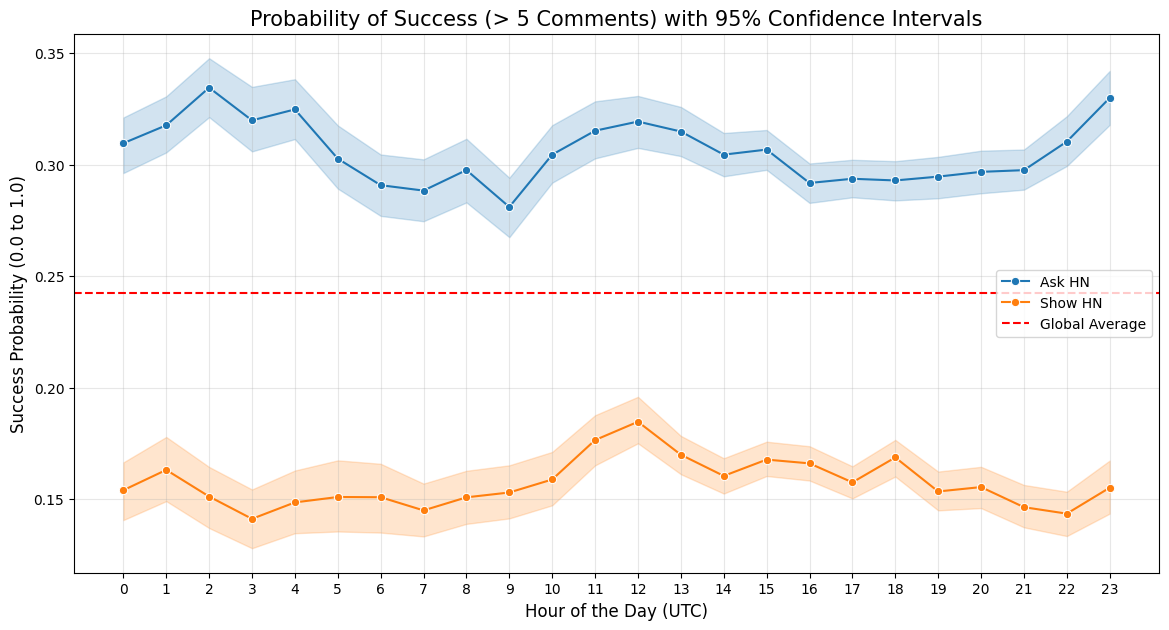

In [28]:
# Ensure the data is filtered for our two target categories
target_posts = df_hn[df_hn['Post Category'].isin(['Ask HN', 'Show HN'])]

# Plotting with Confidence Intervals
plt.figure(figsize=(14, 7))
sns.lineplot(data=target_posts, x='hour', y='is_success', hue='Post Category', marker='o')

plt.title('Probability of Success (> 5 Comments) with 95% Confidence Intervals', fontsize=15)
plt.ylabel('Success Probability (0.0 to 1.0)', fontsize=12)
plt.xlabel('Hour of the Day (UTC)', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.axhline(target_posts['is_success'].mean(), color='red', linestyle='--', label='Global Average')
plt.legend()
plt.show()

### Review of the Final Approach
Looking at the graphs and dataabove, we see that  the "Golden Hour" is actually a myth for this dataset and dat proves this!

If we ook at the Ask HN column, the probability stays between 28% and 33% regardless of the hour. If the "best" hour is 33% and the "worst" is 28%, the time of day only grants you a 5% advantage. We call this a "weak predictor." (low variance)

The gap between Ask HN ~(31%) and Show HN ~(16%) is roughly 15%. This means the **type of post you make is 3x more important than the time you post it.**

**Conclusion:** 

1. The "Ask HN" Advantage

"Ask HN" posts consistently outperform "Show HN" posts in engagement probability. Across all 24 hours, an "Ask HN" post is twice as likely to generate a real discussion (over 5 comments) compared to a "Show HN" post.


2. The Narrow Windows of Opportunity

For Ask HN: The best bet is the late-night/early-morning window (Hours 2 and 23), peaking at 33.4%. This suggests that when there is less "noise" (fewer total posts), high-quality questions have more room to breathe.

For Show HN: The peak occurs at Hour 12 (18.4%). This aligns with lunchtime in the US (EST/CST), where users are likely browsing for interesting new projects during a break.

3. Correlation vs. Reality

Our Spearman Correlation of 0.59 showed that points and comments are related, but this probability table provaes that "Success" is a difficult ceiling to crack. Even at the absolute "best" time, you still have a ~67% chance of failing to reach more than 5 comments on an "Ask HN" post.